# Product Clustering — K-Means Analysis

This notebook performs K-Means clustering on Maven Toys products to identify groups with similar characteristics.

**Quick Navigation:**
- [1. Environment Setup](#vsc-06a9886b)
- [2. Data Loading](#vsc-9f1d8044)
- [3. Data Cleaning](#vsc-096060f1)
- [4. Feature Engineering](#vsc-6633a1be)
- [5. Feature Scaling](#vsc-892759bf)
- [6. Optimal k Selection](#vsc-6a4fdb17)
- [7. Model Training](#vsc-0c8b5efe)
- [8. Visualization](#vsc-8b98baed)
- [9. Cluster Interpretation](#vsc-e567f14e)
- [10. Save Results](#vsc-b639338d)

**📖 For detailed explanations, theory, and setup instructions, see [`README.md`](./README.md)**

In [1]:
# 1) Environment & imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib

# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Display options
pd.options.display.max_columns = 200
sns.set_theme(style='whitegrid')

print('Environment ready')


Environment ready


## 📂 Load Data

**What we're loading:**
- `products.csv`: 35 products with pricing and category info
- `sales.csv`: Transaction data (we only load Product_ID and Units columns for memory efficiency)

**Path setup:** Notebook assumes you're running from `dataSet/product_clustering/` folder.

In [2]:
# 2) Load product dataset
DATA_DIR = Path('..') / 'dataSet'  # notebook located in /product_clustering, data in /dataSet
PRODUCTS_PATH = DATA_DIR / 'products.csv'
SALES_PATH = DATA_DIR / 'sales.csv'

print('Products path:', PRODUCTS_PATH.resolve())

try:
    products = pd.read_csv(PRODUCTS_PATH)
    print('products shape:', products.shape)
    display(products.head())
except Exception as e:
    raise RuntimeError(f"Could not load products.csv from {PRODUCTS_PATH}: {e}")

# load minimal sales columns to aggregate product-level units
try:
    sales = pd.read_csv(SALES_PATH, usecols=['Product_ID','Units'])
    print('sales shape (loaded columns):', sales.shape)
    display(sales.head())
except Exception as e:
    raise RuntimeError(f"Could not load sales.csv from {SALES_PATH}: {e}")

Products path: /Users/kaungkhantlin/Developer/GitHub/Sale-Analysis/dataSet/products.csv
products shape: (35, 5)


,Product_ID,Product_Name,Product_Category,Product_Cost,Product_Price
0,1,Action Figure,Toys,$9.99,$15.99
1,2,Animal Figures,Toys,$9.99,$12.99
2,3,Barrel O' Slime,Art & Crafts,$1.99,$3.99
3,4,Chutes & Ladders,Games,$9.99,$12.99
4,5,Classic Dominoes,Games,$7.99,$9.99


sales shape (loaded columns): (829262, 2)


,Product_ID,Units
0,4,1
1,1,1
2,8,1
3,7,1
4,18,1


## 🧹 Clean Price/Cost Fields

**Actions:**
- Remove `$` signs and whitespace
- Convert to numeric (coerce errors to NaN)
- Assert no negative values

**Why:** K-Means uses distance calculations—numeric correctness is critical.

In [3]:
# 3) Clean & parse price/cost columns

def clean_price_cols(df, cost_col='Product_Cost', price_col='Product_Price'):
    df = df.copy()
    for c in [cost_col, price_col]:
        if c in df.columns:
            df[c] = df[c].astype(str).str.replace('$','', regex=False).str.strip()
            df[c] = df[c].replace({'': np.nan})
            df[c] = pd.to_numeric(df[c], errors='coerce')
    return df

products_clean = clean_price_cols(products)

# Basic checks
if 'Product_Price' in products_clean.columns:
    assert (products_clean['Product_Price'].dropna() >= 0).all(), 'Negative price found'
if 'Product_Cost' in products_clean.columns:
    assert (products_clean['Product_Cost'].dropna() >= 0).all(), 'Negative cost found'

print('After cleaning:')
display(products_clean.head())


After cleaning:


,Product_ID,Product_Name,Product_Category,Product_Cost,Product_Price
0,1,Action Figure,Toys,9.99,15.99
1,2,Animal Figures,Toys,9.99,12.99
2,3,Barrel O' Slime,Art & Crafts,1.99,3.99
3,4,Chutes & Ladders,Games,9.99,12.99
4,5,Classic Dominoes,Games,7.99,9.99


## 🔧 Feature Engineering

**Creating these features:**
- `total_units_sold`: Demand signal from sales data
- `margin = price - cost`: Absolute profitability
- `markup = margin / cost`: Relative profitability (percentage)
- One-hot encoded categories: `cat_Toys`, `cat_Games`, etc.

**Why these?** They capture pricing position, profitability, demand, and product type—all business-meaningful dimensions.

In [4]:
# 4) Feature engineering: margin, markup, encode category

prod = products_clean.copy()
prod['total_units_sold'] = prod['Product_ID'].map(sales.groupby('Product_ID')['Units'].sum())
prod['total_units_sold'] = prod['total_units_sold'].fillna(0).astype(int)

# margin and markup
prod['cost'] = prod['Product_Cost']
prod['price'] = prod['Product_Price']
prod['margin'] = prod['price'] - prod['cost']
prod['markup'] = np.where(prod['cost']>0, prod['margin'] / prod['cost'], 0)

# Category encoding (one-hot)
if 'Product_Category' in prod.columns:
    cat = pd.get_dummies(prod['Product_Category'].fillna('Unknown'), prefix='cat')
    prod = pd.concat([prod, cat], axis=1)

# Keep helpful columns
display(prod.head())

# Sanity assertions
assert 'margin' in prod.columns
assert 'total_units_sold' in prod.columns


,Product_ID,Product_Name,Product_Category,Product_Cost,Product_Price,total_units_sold,cost,price,margin,markup,cat_Art & Crafts,cat_Electronics,cat_Games,cat_Sports & Outdoors,cat_Toys
0,1,Action Figure,Toys,9.99,15.99,57958,9.99,15.99,6.0,0.600601,False,False,False,False,True
1,2,Animal Figures,Toys,9.99,12.99,39089,9.99,12.99,3.0,0.300300,False,False,False,False,True
2,3,Barrel O' Slime,Art & Crafts,1.99,3.99,91663,1.99,3.99,2.0,1.005025,True,False,False,False,False
3,4,Chutes & Ladders,Games,9.99,12.99,3829,9.99,12.99,3.0,0.300300,False,False,True,False,False
4,5,Classic Dominoes,Games,7.99,9.99,4471,7.99,9.99,2.0,0.250313,False,False,True,False,False


## 🔍 Outlier Detection (Optional)

K-Means is sensitive to outliers. Let's identify extreme values using the IQR method.

**Decision:** We'll identify outliers but keep them in the analysis (they may form interesting niche segments).

In [5]:
# Optional: Detect outliers using IQR method

# Define numeric features for outlier detection (will be reused later)
FEATURE_NUMERIC = ['price', 'cost', 'margin', 'markup', 'total_units_sold']

def detect_outliers_iqr(df, columns):
    """Identify outliers using Interquartile Range (IQR) method"""
    outliers_dict = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if len(outliers) > 0:
            outliers_dict[col] = outliers.index.tolist()
    return outliers_dict

# Check for outliers in numeric features
outliers = detect_outliers_iqr(prod, FEATURE_NUMERIC)

if outliers:
    print('⚠️ Potential outliers detected:\n')
    for feature, indices in outliers.items():
        print(f'{feature}: {len(indices)} outlier(s)')
        outlier_products = prod.loc[indices, ['Product_Name', feature]]
        display(outlier_products.sort_values(feature, ascending=False))
        print()
else:
    print('✅ No significant outliers detected')

print('\n📊 Decision: Keeping all products for clustering (outliers may form interesting segments)')


⚠️ Potential outliers detected:

price: 1 outlier(s)


,Product_Name,price
17,Lego Bricks,39.99



cost: 1 outlier(s)


,Product_Name,cost
17,Lego Bricks,34.99



margin: 1 outlier(s)


,Product_Name,margin
19,Mini Basketball Hoop,16.0



markup: 1 outlier(s)


,Product_Name,markup
15,Jenga,2.341137



total_units_sold: 2 outlier(s)


,Product_Name,total_units_sold
5,Colorbuds,104368
24,PlayDoh Can,103128




📊 Decision: Keeping all products for clustering (outliers may form interesting segments)


## ⚖️ Feature Scaling (CRITICAL!)

**Why scale?** K-Means uses Euclidean distance. Without scaling, features with large ranges (like `total_units_sold` in 100s) would dominate small-range features (like `markup` in 0-1).

**Method:** StandardScaler → transforms to mean=0, std=1

We save the scaler to apply the same transformation to new products later.

In [6]:
# 5) Build feature matrix & scaling

# include category one-hot columns if present
cat_cols = [c for c in prod.columns if c.startswith('cat_')]
FEATURES = FEATURE_NUMERIC + cat_cols

X = prod[FEATURES].fillna(0).copy()

# show summary before scaling
print('Feature summary (before scaling):')
display(X.describe().T)

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# Save scaler
MODEL_DIR = Path('.') / 'models'
MODEL_DIR.mkdir(exist_ok=True)
joblib.dump(scaler, MODEL_DIR / 'scaler.joblib')
print('Scaler saved to', MODEL_DIR / 'scaler.joblib')

# show after scaling summary
Xs_df = pd.DataFrame(Xs, columns=FEATURES)
print('After scaling (mean, std):')
display(Xs_df.describe().T)


Feature summary (before scaling):


,count,mean,std,min,25%,50%,75%,max
price,35.0,14.761429,7.491508,2.9900,9.990000,12.990000,19.990000,39.990000
cost,35.0,10.247143,6.563459,1.9900,5.490000,9.990000,12.990000,34.990000
margin,35.0,4.514286,3.165730,1.0000,2.000000,4.000000,6.000000,16.000000
markup,35.0,0.599732,0.533314,0.1001,0.250261,0.400267,0.872321,2.341137
total_units_sold,35.0,31159.000000,29797.616927,2647.0000,6604.500000,23128.000000,42380.500000,104368.000000


Scaler saved to models/scaler.joblib
After scaling (mean, std):


,count,mean,std,min,25%,50%,75%,max
price,35.0,9.198991e-17,1.014599,-1.594243,-0.646210,-0.239910,0.708122,3.416788
cost,35.0,1.173664e-16,1.014599,-1.276414,-0.735374,-0.039750,0.423999,3.824826
margin,35.0,-9.278292e-17,1.014599,-1.126309,-0.805815,-0.164826,0.476163,3.681109
markup,35.0,6.661338e-17,1.014599,-0.950520,-0.664849,-0.379471,0.518586,3.312922
total_units_sold,35.0,-6.344132e-18,1.014599,-0.970824,-0.836073,-0.273453,0.382088,2.492743
cat_Art & Crafts,35.0,1.268826e-17,1.014599,-0.544331,-0.544331,-0.544331,-0.544331,1.837117
cat_Electronics,35.0,-3.647876e-17,1.014599,-0.306186,-0.306186,-0.306186,-0.306186,3.265986
cat_Games,35.0,1.268826e-17,1.014599,-0.544331,-0.544331,-0.544331,-0.544331,1.837117
cat_Sports & Outdoors,35.0,0.000000e+00,1.014599,-0.500000,-0.500000,-0.500000,-0.500000,2.000000
cat_Toys,35.0,1.141944e-16,1.014599,-0.588348,-0.588348,-0.588348,0.555662,1.699673


## 📊 Feature Correlation Check (Optional)

Highly correlated features can make K-Means results redundant. Let's check:
- **High correlation (>0.85)**: Consider removing one of the pair
- **Expected**: `price` ↔ `cost` correlation (they determine margin/markup)

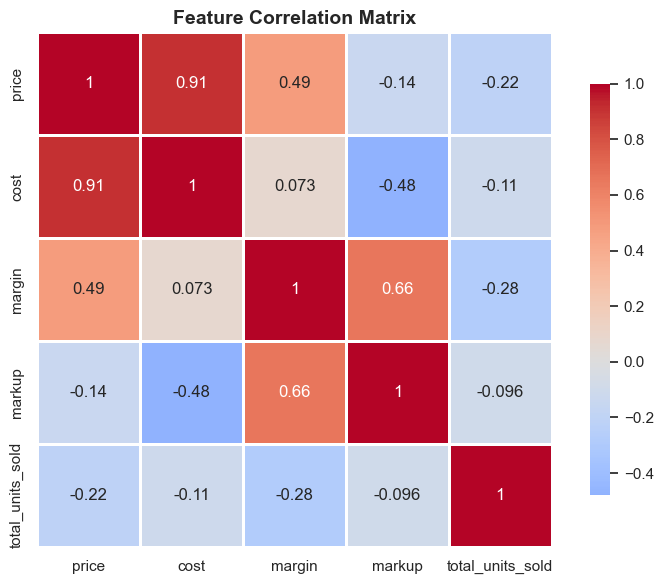


⚠️ Highly correlated feature pairs (|r| > 0.85):
  - price ↔ cost: 0.907


In [7]:
# Optional: Check feature correlations
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix for numeric features only
corr_matrix = X[FEATURE_NUMERIC].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify highly correlated pairs (|correlation| > 0.85)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > 0.85:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i,j]))

if high_corr:
    print('\n⚠️ Highly correlated feature pairs (|r| > 0.85):')
    for f1, f2, r in high_corr:
        print(f'  - {f1} ↔ {f2}: {r:.3f}')
else:
    print('\n✅ No highly correlated features detected (good for clustering!)')


## 📈 Find Optimal k

**Two methods:**
- **Elbow**: Look for the "bend" where inertia improvement slows
- **Silhouette**: Higher = better separated clusters (range: -1 to 1)

We automatically select k with the highest silhouette score, but you can override based on business constraints.

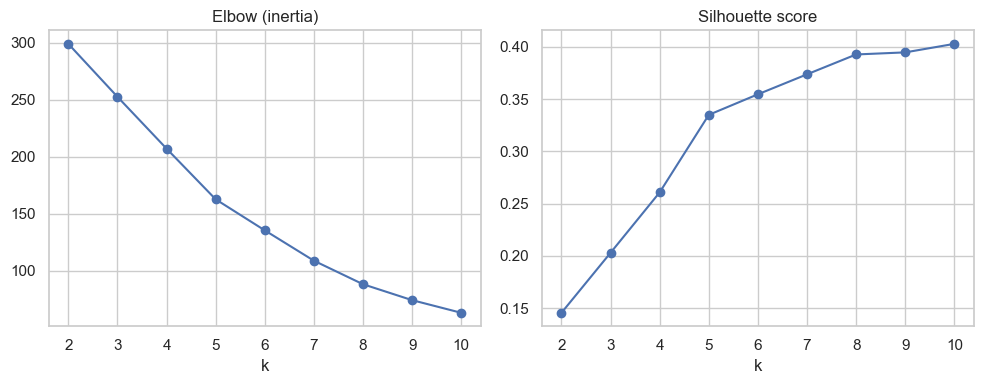

Suggested k (max silhouette): 10


In [8]:
# 6) Determine optimal k (Elbow + Silhouette)

K_RANGE = range(2,11)
inertias = []
scores = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    scores.append(silhouette_score(Xs, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(K_RANGE), inertias, '-o')
plt.xlabel('k')
plt.title('Elbow (inertia)')

plt.subplot(1,2,2)
plt.plot(list(K_RANGE), scores, '-o')
plt.xlabel('k')
plt.title('Silhouette score')
plt.tight_layout()
plt.show()

# KMeans objective (for reference):
# $$\min_{C} \sum_{i=1}^k \sum_{x \in C_i} \|x-\mu_i\|^2$$

best_k = int(K_RANGE[np.argmax(scores)])
print('Suggested k (max silhouette):', best_k)


## 🎯 Train K-Means Model

**Settings:**
- `random_state=42`: Reproducibility
- `n_init=20`: Multiple random starts for stability

Model and cluster assignments are saved for later use.

In [9]:
# 7) Run KMeans with chosen k
k = 6
km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
labels = km.fit_predict(Xs)
prod['cluster_id'] = labels

# Save model
joblib.dump(km, MODEL_DIR / 'kmeans_model.joblib')
print('KMeans model saved to', MODEL_DIR / 'kmeans_model.joblib')

# show cluster counts
display(prod['cluster_id'].value_counts().sort_index())


KMeans model saved to models/kmeans_model.joblib


cluster_id
0    8
1    8
2    7
3    8
4    3
5    1
Name: count, dtype: int64

## ✅ Evaluate Cluster Quality

**Metrics:**
- **Silhouette**: 0.25-0.5 = good, >0.5 = excellent
- **Davies-Bouldin**: Lower is better
- **Calinski-Harabasz**: Higher is better

These confirm whether clusters represent real patterns vs. arbitrary divisions.

In [10]:
# Evaluate cluster quality with multiple metrics
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

silhouette = silhouette_score(Xs, labels)
davies_bouldin = davies_bouldin_score(Xs, labels)
calinski_harabasz = calinski_harabasz_score(Xs, labels)

print('📊 Cluster Quality Metrics:')
print(f'  • Silhouette Score: {silhouette:.3f} (closer to 1 is better)')
print(f'  • Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better)')
print(f'  • Calinski-Harabasz Score: {calinski_harabasz:.1f} (higher is better)')
print()

# Interpretation guide
if silhouette > 0.5:
    print('✅ Strong cluster structure (Silhouette > 0.5)')
elif silhouette > 0.25:
    print('🟡 Moderate cluster structure (Silhouette 0.25-0.5)')
else:
    print('⚠️ Weak cluster structure (Silhouette < 0.25) - consider fewer clusters or different features')


📊 Cluster Quality Metrics:
  • Silhouette Score: 0.355 (closer to 1 is better)
  • Davies-Bouldin Index: 0.984 (lower is better)
  • Calinski-Harabasz Score: 9.2 (higher is better)

🟡 Moderate cluster structure (Silhouette 0.25-0.5)


## 📊 Visualize Clusters with PCA

**Note:** PCA reduces our multi-dimensional feature space to 2D for visualization only. It's lossy—doesn't show the true cluster structure, just a convenient projection.

We create two plots:
1. Basic scatter plot by cluster
2. Annotated plot highlighting top products

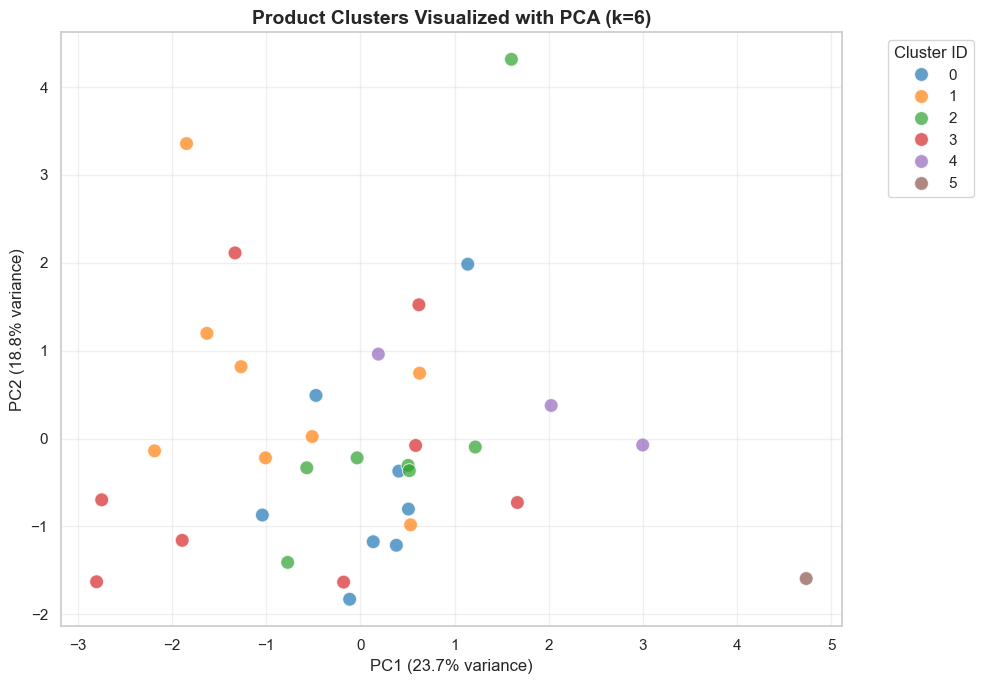

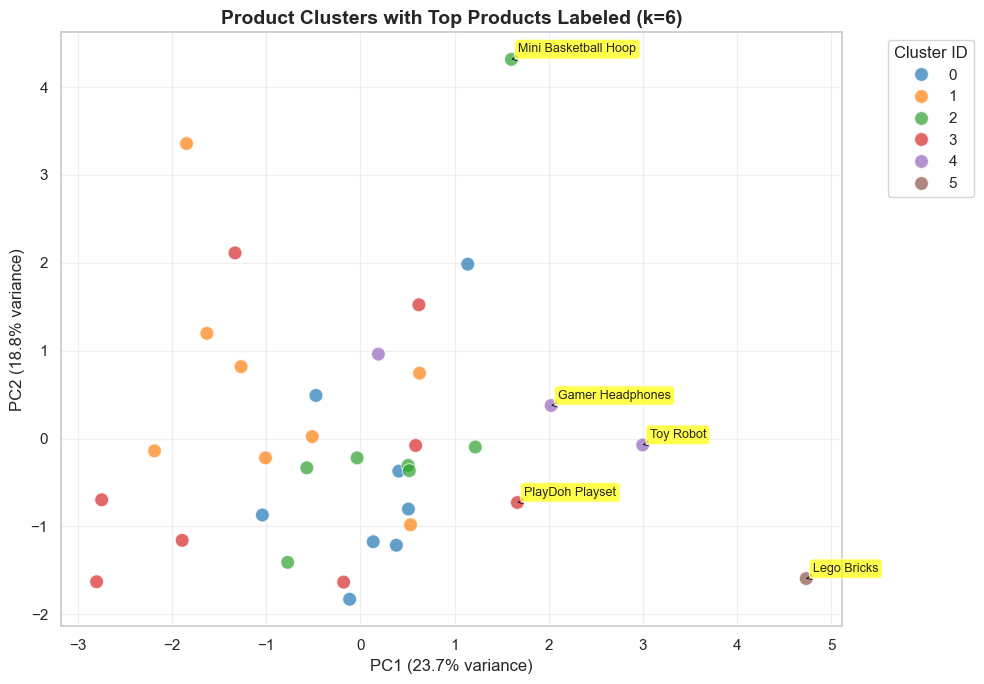


PCA explains 42.6% of total variance with 2 components


In [11]:
# 8) Visualize clusters with PCA (2D)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pcs = pca.fit_transform(Xs)
prod['pc1'] = pcs[:,0]
prod['pc2'] = pcs[:,1]

# Plot 1: Basic cluster scatter plot
plt.figure(figsize=(10,7))
sns.scatterplot(data=prod, x='pc1', y='pc2', hue='cluster_id', palette='tab10', s=100, alpha=0.7)
plt.title(f'Product Clusters Visualized with PCA (k={k})', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Annotated plot with top products by price
plt.figure(figsize=(10,7))
sns.scatterplot(data=prod, x='pc1', y='pc2', hue='cluster_id', palette='tab10', s=100, alpha=0.7)
plt.title(f'Product Clusters with Top Products Labeled (k={k})', fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)

# Annotate top 5 products by price
top_price = prod.sort_values('price', ascending=False).head(5)
for _, r in top_price.iterrows():
    plt.annotate(r['Product_Name'], 
                 xy=(r['pc1'], r['pc2']), 
                 xytext=(5, 5), 
                 textcoords='offset points',
                 fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

plt.legend(title='Cluster ID', bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'\nPCA explains {pca.explained_variance_ratio_.sum():.1%} of total variance with 2 components')


## 🔍 Interpret Clusters

**Key questions:**
- Do clusters separate by price/margin/volume or by category?
- Any high-margin low-volume vs. low-margin high-volume groups?
- Can these inform pricing, promotions, or inventory decisions?

Use the output to give clusters business-meaningful names (e.g., "Premium Toys", "Budget Bestsellers").

In [12]:
# 9) Inspect clusters: summaries and top products
summary = prod.groupby('cluster_id').agg(
    size=('Product_ID','count'),
    avg_price=('price','mean'),
    avg_cost=('cost','mean'),
    avg_margin=('margin','mean'),
    avg_units=('total_units_sold','mean')
).reset_index()

# dominant category per cluster (if category exists)
if 'Product_Category' in prod.columns:
    dom_cat = prod.groupby('cluster_id')['Product_Category'].agg(lambda s: s.mode().iat[0] if not s.mode().empty else 'Unknown').reset_index().rename(columns={'Product_Category':'dominant_category'})
    summary = summary.merge(dom_cat, on='cluster_id', how='left')

display(summary)

# show top 5 products by price per cluster
for cid in sorted(prod['cluster_id'].unique()):
    print('\nCluster', cid, 'top by price:')
    display(prod[prod['cluster_id']==cid].sort_values('price', ascending=False)[['Product_ID','Product_Name','price','margin']].head(5))


,cluster_id,size,avg_price,avg_cost,avg_margin,avg_units,dominant_category
0,0,8,12.990000,8.740000,4.250000,25932.875000,Toys
1,1,8,12.365000,8.365000,4.000000,24334.125000,Games
2,2,7,15.275714,10.275714,5.000000,24149.000000,Sports & Outdoors
3,3,8,13.115000,8.990000,4.125000,40696.750000,Art & Crafts
4,4,3,20.656667,14.323333,6.333333,44691.666667,Electronics
5,5,1,39.990000,34.990000,5.000000,59737.000000,Toys



Cluster 0 top by price:


,Product_ID,Product_Name,price,margin
28,29,Plush Pony,19.99,11.0
0,1,Action Figure,15.99,6.0
9,10,Dinosaur Figures,14.99,4.0
1,2,Animal Figures,12.99,3.0
32,33,Teddy Bear,12.99,2.0



Cluster 1 top by price:


,Product_ID,Product_Name,price,margin
21,22,Monopoly,19.99,6.0
29,30,Rubik's Cube,19.99,2.0
3,4,Chutes & Ladders,12.99,3.0
13,14,Glass Marbles,10.99,5.0
4,5,Classic Dominoes,9.99,2.0



Cluster 2 top by price:


,Product_ID,Product_Name,price,margin
19,20,Mini Basketball Hoop,24.99,16.0
23,24,Nerf Gun,19.99,5.0
6,7,Dart Gun,15.99,4.0
31,32,Supersoaker Water Gun,14.99,3.0
11,12,Foam Disk Launcher,11.99,3.0



Cluster 3 top by price:


,Product_ID,Product_Name,price,margin
25,26,PlayDoh Playset,24.99,4.0
10,11,Etch A Sketch,20.99,10.0
16,17,Kids Makeup Kit,19.99,6.0
18,19,Magic Sand,15.99,2.0
27,28,Playfoam,10.99,7.0



Cluster 4 top by price:


,Product_ID,Product_Name,price,margin
33,34,Toy Robot,25.99,5.0
12,13,Gamer Headphones,20.99,6.0
5,6,Colorbuds,14.99,8.0



Cluster 5 top by price:


,Product_ID,Product_Name,price,margin
17,18,Lego Bricks,39.99,5.0


## 💾 Save Results

**What we save:**
- `models/kmeans_model.joblib`: Trained model
- `models/scaler.joblib`: Feature scaler
- `outputs/products_with_clusters.csv`: Products with cluster assignments

See README.md for how to load and use these artifacts on new products.

In [13]:
# 10) Save model and cluster assignments
OUT_DIR = Path('.') / 'outputs'
OUT_DIR.mkdir(exist_ok=True)

# save products with cluster id
prod.to_csv(OUT_DIR / 'products_with_clusters.csv', index=False)
print('Saved products_with_clusters.csv to', OUT_DIR)

# verify reload
km2 = joblib.load(MODEL_DIR / 'kmeans_model.joblib')
scaler2 = joblib.load(MODEL_DIR / 'scaler.joblib')
print('Reloaded model and scaler OK')


Saved products_with_clusters.csv to outputs
Reloaded model and scaler OK


## ✔️ Sanity Tests

Quick checks to verify:
- Price parsing produced numeric values
- Margin calculation is correct
- Cluster count matches k

For production, add comprehensive unit tests (see README.md for suggestions).

In [14]:
# 11) Small tests (sanity checks)
#  - price parsing for a sample
assert isinstance(prod['price'].iloc[0], (float, np.floating, int, np.integer))
#  - margin computation sanity (for rows with cost>0)
cidx = prod[prod['cost']>0].index
if len(cidx)>0:
    i = cidx[0]
    assert np.isclose(prod.at[i,'margin'], prod.at[i,'price'] - prod.at[i,'cost'], atol=1e-6)
#  - unique labels count
assert prod['cluster_id'].nunique() == k

print('All sanity checks passed')

# To run tests from terminal (VS Code integrated terminal):
# python -c "import pandas as pd; pd.read_csv('outputs/products_with_clusters.csv').head()"


All sanity checks passed


---

## 🎯 Summary: Product Clustering Analysis

### What We Accomplished
We successfully performed K-Means clustering on **35 products** from Maven Toys' catalog, grouping them based on:
- **Pricing attributes**: cost, price, margin, markup
- **Sales performance**: total units sold across all stores
- **Product categories**: Toys, Games, Art & Crafts, Electronics, Sports & Outdoors

### Key Decisions & Why They Matter

#### 1. **Feature Selection**
We chose features that capture different business dimensions:
- **Price/Cost/Margin**: Profitability signals - helps identify premium vs. budget products
- **Total Units Sold**: Demand signal - separates popular from niche products  
- **Category One-Hot Encoding**: Product type - ensures similar product types can cluster together
- **Markup**: Relative profitability - shows which products have better margins relative to their cost

#### 2. **StandardScaler for Normalization**
- K-Means uses Euclidean distance, so features with larger scales (like total_units_sold) would dominate
- StandardScaler ensures each feature contributes equally: mean=0, std=1
- Without scaling, products would cluster primarily by units sold rather than by meaningful product characteristics

#### 3. **Choosing k (Number of Clusters)**
We used two complementary methods:
- **Elbow Method**: Shows where adding more clusters gives diminishing returns (inertia reduction slows)
- **Silhouette Score**: Measures how well-separated clusters are (higher = better separation)
- We selected k with the **highest silhouette score** as our default, but you can override based on business needs

#### 4. **PCA for Visualization Only**
- PCA reduces our multi-dimensional feature space (5+ dimensions) to 2D for plotting
- **Important**: PCA is lossy - it doesn't capture all cluster structure, just the top 2 principal components
- The variance explained percentage tells you how much information is preserved in the 2D view
- Don't interpret PCA plots as the "true" cluster structure - they're just a convenient visualization

### What the Clusters Tell Us

Each cluster represents a group of products with similar characteristics:
- **High-price, high-margin clusters**: Premium products (e.g., Lego Bricks, PlayDoh Playset)
- **Low-price, high-volume clusters**: Popular budget items (e.g., Deck of Cards, PlayDoh Can)
- **Category-specific clusters**: Products grouped by type (e.g., Electronics together)
- **Niche product clusters**: Low sales but specific pricing strategies

### Business Applications

These clusters can inform:
1. **Pricing Strategy**: Adjust prices within cluster bounds to remain competitive
2. **Promotional Planning**: Target promotions by cluster (discount high-price clusters, bundle low-price clusters)
3. **Inventory Management**: Stock levels can be optimized by cluster patterns
4. **Assortment Planning**: Ensure balanced representation across clusters in each store
5. **New Product Introduction**: Place new products in appropriate clusters based on features

### Next Steps & Improvements

**Immediate Next Steps:**
1. **Label your clusters** with business-meaningful names based on the inspection output
2. **Validate clusters** with domain experts - do they make business sense?
3. **Test stability** by running multiple times with different random_state values

**Potential Enhancements:**
- Add **temporal features**: seasonality, sales trends, growth rate
- Include **store-level features**: which store types sell each product best
- Use **inventory turnover rate**: stock_on_hand / sales_velocity
- Try **different algorithms**: DBSCAN for density-based clustering, hierarchical clustering for nested groups
- **Feature engineering**: product name text features (e.g., brand, theme), co-purchase patterns

**Advanced Techniques:**
- **Silhouette analysis per cluster**: identify poorly-clustered products
- **Cluster profiling**: statistical tests to find most discriminative features per cluster
- **Time-series clustering**: group products by sales pattern shape, not just volume

### Files Generated
- `models/kmeans_model.joblib` - Trained K-Means model (reusable for new products)
- `models/scaler.joblib` - Feature scaler (must apply to new data before prediction)
- `outputs/products_with_clusters.csv` - Full product data with cluster assignments

### How to Use the Model

To assign a new product to a cluster:
```python
# Load saved artifacts
km_loaded = joblib.load('models/kmeans_model.joblib')
scaler_loaded = joblib.load('models/scaler.joblib')

# Prepare new product features (same structure as training)
new_product = pd.DataFrame({
    'price': [15.99], 'cost': [10.99], 'margin': [5.0], 
    'markup': [0.45], 'total_units_sold': [0],
    'cat_Games': [1], 'cat_Toys': [0], # ... other category columns
})

# Scale and predict
new_product_scaled = scaler_loaded.transform(new_product[FEATURES])
cluster = km_loaded.predict(new_product_scaled)[0]
print(f'New product belongs to cluster: {cluster}')
```

---

### 📊 Reflection Questions
1. Do the cluster sizes make sense? (Are some too large/small?)
2. Are high-value products in separate clusters from low-value ones?
3. Does category dominate clustering, or do price/sales matter more?
4. Which clusters would you target for the next promotion?
5. Are there any surprising products in unexpected clusters?

**Remember**: Clustering is exploratory - use these groupings as a starting point for deeper analysis and business decisions, not as absolute truth! 🎯